In [1]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler
import warnings 
import os
warnings.filterwarnings("ignore")

# Convert timestamps to timecodes for both datasets


c:\Users\PRIYANSHU\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler
import os

# Function to preprocess a dataframe
def preprocess_dataframe(df, column_name):
    # 1. Replace 0 values with the median of non-zero values
    non_zero_median = df[column_name][df[column_name] != 0].median()
    df[column_name] = df[column_name].replace(0, non_zero_median)

    # 2. Winsorize to limit outliers (cap at 5th and 95th percentiles)
    df[column_name] = winsorize(df[column_name], limits=[0.05, 0.05])

    # 3. Apply Min-Max Scaling
    scaler = MinMaxScaler()
    df[f"{column_name}_scaled"] = scaler.fit_transform(df[[column_name]])
    
    return df

# List of names
names = ['amog', 'anushka', 'aryaman', 'jain', 'priyansh', 'priyanshu', 'rhea', 'sani', 'suhani', 'surabhi', 'tanya', 'trusha', 'vaish']

# List of suffixes for the filenames to preprocess
preprocess_suffixes = ['v1', 'v2', 'v3', 'v4']
preprocess_suffixes1 = ['1', '2', '3', '4']

# Loop through names and suffixes to preprocess only the CSV files ending with _v1, _v2, _v3, _v4
for name in names:
    for suffix in preprocess_suffixes:
        # Construct the filename
        filename = f"{name}_{suffix}.csv"
        
        try:
            # Check if the file exists
            if os.path.isfile(filename):
                # Read the CSV file into a dataframe
                df = pd.read_csv(filename)
                
                # Print the name of the dataframe being created
                df_name = f"{name}_{suffix}"
                print(f"Creating and processing dataframe: {df_name}")
                
                # Apply the preprocessing function to the dataframe
                df = preprocess_dataframe(df, 'pupil-area')
                
                # Save the preprocessed dataframe back to the CSV file
                df.to_csv(filename, index=False)
                
                print(f"Processed and saved: {filename}")
            else:
                print(f"File not found: {filename}")
        
        except Exception as e:
            print(f"Error processing {filename}: {e}")


In [ ]:
for name in names:
    for suffix in preprocess_suffixes1:
        # Construct the filename
        filename = f"{name}{suffix}.csv"
        
        try:
            # Check if the file exists
            if os.path.isfile(filename):
                # Read the CSV file into a dataframe
                df = pd.read_csv(filename)
                
                # Print the name of the dataframe being created
                df_name = f"click_{name}{suffix}"
                print(f"Creating and processing dataframe: {df_name}")
                df = preprocess_dataframe(df, 'pupil-area')
                
                # Save the preprocessed dataframe back to the CSV file
                df.to_csv(filename, index=False)
                
                print(f"Processed and saved: {filename}")
            else:
                print(f"File not found: {filename}")
        
        except Exception as e:
            print(f"Error processing {filename}: {e}")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# List of names
names = ['amog', 'anushka', 'aryaman', 'jain', 'priyansh', 'priyanshu', 'rhea', 'sani', 'suhani', 'surabhi', 'tanya', 'trusha', 'vaish']

# Function to preprocess dataframes before merging
def preprocess_dataframes2(click_data, pupil_data):
    # Convert Timecode columns to numeric
    click_data['Timecode (seconds)'] = pd.to_numeric(click_data['Timecode (seconds)'], errors='coerce')
    pupil_data['timecode'] = pd.to_numeric(pupil_data['timecode'], errors='coerce')

    # Add 'Is Promotional' column if it doesn't exist
    if 'Is Promotional' not in click_data.columns:
        click_data['Is Promotional'] = 'FALSE'

# Function to merge on time intervals
def merge_on_time_intervals(click_data, pupil_data, time_window=5):
    merged_data = []

    # Iterate through each click data row
    for _, click_row in click_data.iterrows():
        click_time = click_row['Timecode (seconds)']
        product_is_promotional = click_row['Is Promotional']
        
        # Find the range of pupil data around the click time (± time_window seconds)
        time_range_start = click_time - time_window
        time_range_end = click_time + time_window

        # Select the relevant pupil data in this time window
        relevant_pupil_data = pupil_data[(pupil_data['timecode'] >= time_range_start) & (pupil_data['timecode'] <= time_range_end)]
        
        # Calculate the average pupil area for the selected time range
        avg_pupil_area = relevant_pupil_data['pupil-area'].mean()

        # Store merged data with additional info
        merged_data.append({
            'Product Name': click_row['Product Name'],
            'Is Promotional': product_is_promotional,
            'Click Timecode': click_time,
            'Average Pupil Area': avg_pupil_area
        })

    return pd.DataFrame(merged_data)

# Function to calculate pre- and post-click pupil areas
def calculate_pre_post_pupil_areas(promotional_clicks, pupil_data):
    results = []

    for _, click_row in promotional_clicks.iterrows():
        click_time = click_row['Timecode (seconds)']
        product_name = click_row['Product Name']

        # Pre-click window: 5 seconds before the click
        pre_click_start = click_time - 5
        pre_click_end = click_time
        pre_click_pupil_area = pupil_data[
            (pupil_data['timecode'] >= pre_click_start) & (pupil_data['timecode'] < pre_click_end)
        ]['pupil-area'].mean()

        # Post-click window: 3 seconds starting 2 seconds after the click
        post_click_start = click_time + 2
        post_click_end = click_time + 5
        post_click_pupil_area = pupil_data[
            (pupil_data['timecode'] >= post_click_start) & (pupil_data['timecode'] < post_click_end)
        ]['pupil-area'].mean()

        # Append the results
        results.append({
            'Product Name': product_name,
            'Click Timecode': click_time,
            'Pre-Click Avg Pupil Area': pre_click_pupil_area,
            'Post-Click Avg Pupil Area': post_click_pupil_area
        })

    return pd.DataFrame(results)

# Loop through names and process each relevant dataframe pair
for name in names:
    for i in range(1, 5):  # For v1, v2, v3, v4
        pupil_filename = f"{name}_v{i}.csv"
        click_filename = f"{name}{i}.csv"
        
        try:
            # Check if both files exist
            if os.path.isfile(pupil_filename) and os.path.isfile(click_filename):
                # Read the CSV files into dataframes
                pupil_data = pd.read_csv(pupil_filename)
                click_data = pd.read_csv(click_filename)

                # Print the names of the dataframes being created
                print(f"Reading and processing: {pupil_filename}, {click_filename}")

                # Preprocess the dataframes (including adding 'Is Promotional' if missing)
                preprocess_dataframes2(click_data, pupil_data)

                # Merge datasets
                merged_data = merge_on_time_intervals(click_data, pupil_data, time_window=5)

                # Group by 'Is Promotional' and calculate the mean pupil area
                pupil_area_comparison = merged_data.groupby('Is Promotional')['Average Pupil Area'].mean()

                # Plot the comparison
                plt.figure(figsize=(6, 4))
                pupil_area_comparison.plot(kind='bar', color=['skyblue', 'lightcoral'])
                plt.title(f'Average Pupil Area for Promotional vs Non-Promotional Products ({name} v{i})')
                plt.xlabel('Is Promotional')
                plt.ylabel('Average Pupil Area')
                plt.xticks([0, 1], ['Non-Promotional', 'Promotional'], rotation=0)
                plt.tight_layout()
                plt.show()

                # Filter clicks for promotional items only
                promotional_clicks = click_data[click_data['Is Promotional'] == True]

                # Calculate the pre- and post-click pupil areas
                pre_post_pupil_areas = calculate_pre_post_pupil_areas(promotional_clicks, pupil_data)

                # Print the results
                print(f"Pre- and Post-Click Pupil Areas for {name} v{i}:")
                print(pre_post_pupil_areas)
                print("-" * 50)

            else:
                print(f"File not found: {pupil_filename} or {click_filename}")

        except Exception as e:
            print(f"Error processing {name} v{i}: {e}")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# List of names
names = ['amog', 'anushka', 'aryaman', 'jain', 'priyansh', 'priyanshu', 'rhea', 'sani', 'suhani', 'surabhi', 'tanya', 'trusha', 'vaish']

# Function to preprocess dataframes before merging
def preprocess_dataframes2(click_data, pupil_data):
    # Convert Timecode columns to numeric
    click_data['Timecode (seconds)'] = pd.to_numeric(click_data['Timecode (seconds)'], errors='coerce')
    pupil_data['timecode'] = pd.to_numeric(pupil_data['timecode'], errors='coerce')

    # Add 'Is Promotional' column if it doesn't exist
    if 'Is Promotional' not in click_data.columns:
        click_data['Is Promotional'] = 'FALSE'

# Function to merge on time intervals
def merge_on_time_intervals(click_data, pupil_data, time_window=5):
    merged_data = []

    # Iterate through each click data row
    for _, click_row in click_data.iterrows():
        click_time = click_row['Timecode (seconds)']
        product_is_promotional = click_row['Is Promotional']
        
        # Find the range of pupil data around the click time (± time_window seconds)
        time_range_start = click_time - time_window
        time_range_end = click_time + time_window

        # Select the relevant pupil data in this time window
        relevant_pupil_data = pupil_data[(pupil_data['timecode'] >= time_range_start) & (pupil_data['timecode'] <= time_range_end)]
        
        # Calculate the average pupil area for the selected time range
        avg_pupil_area = relevant_pupil_data['pupil-area'].mean()

        # Store merged data with additional info
        merged_data.append({
            'Product Name': click_row['Product Name'],
            'Is Promotional': product_is_promotional,
            'Click Timecode': click_time,
            'Average Pupil Area': avg_pupil_area
        })

    return pd.DataFrame(merged_data)

# Function to calculate pre- and post-click pupil areas
def calculate_pre_post_pupil_areas(promotional_clicks, pupil_data):
    results = []

    for _, click_row in promotional_clicks.iterrows():
        click_time = click_row['Timecode (seconds)']
        product_name = click_row['Product Name']

        # Pre-click window: 5 seconds before the click
        pre_click_start = click_time - 5
        pre_click_end = click_time
        pre_click_pupil_area = pupil_data[
            (pupil_data['timecode'] >= pre_click_start) & (pupil_data['timecode'] < pre_click_end)
        ]['pupil-area'].mean()

        # Post-click window: 3 seconds starting 2 seconds after the click
        post_click_start = click_time + 2
        post_click_end = click_time + 5
        post_click_pupil_area = pupil_data[
            (pupil_data['timecode'] >= post_click_start) & (pupil_data['timecode'] < post_click_end)
        ]['pupil-area'].mean()

        # Append the results
        results.append({
            'Product Name': product_name,
            'Click Timecode': click_time,
            'Pre-Click Avg Pupil Area': pre_click_pupil_area,
            'Post-Click Avg Pupil Area': post_click_pupil_area
        })

    return pd.DataFrame(results)

# Loop through names and process each relevant dataframe pair
for name in names:
    for i in range(1, 5):  # For v1, v2, v3, v4
        pupil_filename = f"{name}_v{i}.csv"
        click_filename = f"{name}{i}.csv"
        
        try:
            # Check if both files exist
            if os.path.isfile(pupil_filename) and os.path.isfile(click_filename):
                # Read the CSV files into dataframes
                pupil_data = pd.read_csv(pupil_filename)
                click_data = pd.read_csv(click_filename)

                # Print the names of the dataframes being created
                print(f"Reading and processing: {pupil_filename}, {click_filename}")

                # Preprocess the dataframes (including adding 'Is Promotional' if missing)
                preprocess_dataframes2(click_data, pupil_data)

                # Merge datasets
                merged_data = merge_on_time_intervals(click_data, pupil_data, time_window=5)

                # Group by 'Is Promotional' and calculate the mean pupil area
                pupil_area_comparison = merged_data.groupby('Is Promotional')['Average Pupil Area'].mean()

                # Plot the comparison
                plt.figure(figsize=(6, 4))
                pupil_area_comparison.plot(kind='bar', color=['skyblue', 'lightcoral'])
                plt.title(f'Average Pupil Area for Promotional vs Non-Promotional Products ({name} v{i})')
                plt.xlabel('Is Promotional')
                plt.ylabel('Average Pupil Area')
                plt.xticks([0, 1], ['Non-Promotional', 'Promotional'], rotation=0)
                plt.tight_layout()
                plt.show()

                # Filter clicks for promotional items only
                promotional_clicks = click_data[click_data['Is Promotional'] == True]

                # Calculate the pre- and post-click pupil areas
                pre_post_pupil_areas = calculate_pre_post_pupil_areas(promotional_clicks, pupil_data)

                # Print the results
                print(f"Pre- and Post-Click Pupil Areas for {name} v{i}:")
                print(pre_post_pupil_areas)
                print("-" * 50)

            else:
                print(f"File not found: {pupil_filename} or {click_filename}")

        except Exception as e:
            print(f"Error processing {name} v{i}: {e}")


Reading and processing: amog_v2.csv, amog2.csv
Reading and processing: amog_v4.csv, amog4.csv
Reading and processing: anushka_v2.csv, anushka2.csv
Reading and processing: anushka_v4.csv, anushka4.csv
Reading and processing: aryaman_v2.csv, aryaman2.csv
Reading and processing: aryaman_v4.csv, aryaman4.csv
Reading and processing: jain_v2.csv, jain2.csv
Reading and processing: jain_v4.csv, jain4.csv
Reading and processing: priyansh_v2.csv, priyansh2.csv
Reading and processing: priyansh_v4.csv, priyansh4.csv
Reading and processing: priyanshu_v2.csv, priyanshu2.csv
Reading and processing: priyanshu_v4.csv, priyanshu4.csv
Reading and processing: rhea_v2.csv, rhea2.csv
Reading and processing: rhea_v4.csv, rhea4.csv
Reading and processing: sani_v2.csv, sani2.csv
Reading and processing: sani_v4.csv, sani4.csv
Reading and processing: suhani_v2.csv, suhani2.csv
Reading and processing: suhani_v4.csv, suhani4.csv
Reading and processing: surabhi_v2.csv, surabhi2.csv
Reading and processing: surabhi_v

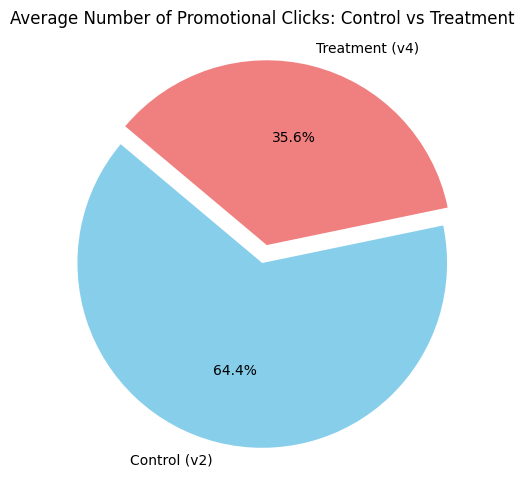

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# List of names
names = ['amog', 'anushka', 'aryaman', 'jain', 'priyansh', 'priyanshu', 'rhea', 'sani', 'suhani', 'surabhi', 'tanya', 'trusha', 'vaish']

# Function to preprocess dataframes before merging
def preprocess_dataframes2(click_data, pupil_data):
    # Convert Timecode columns to numeric
    click_data['Timecode (seconds)'] = pd.to_numeric(click_data['Timecode (seconds)'], errors='coerce')
    pupil_data['timecode'] = pd.to_numeric(pupil_data['timecode'], errors='coerce')

    # Add 'Is Promotional' column if it doesn't exist
    if 'Is Promotional' not in click_data.columns:
        click_data['Is Promotional'] = False

# Initialize lists to store results
control_promotional_counts = []
treatment_promotional_counts = []
count = [2,4]
# Loop through names and process each relevant dataframe pair
for name in names:
    for i in count:  # For v1 (control) and v2 (treatment)
        pupil_filename = f"{name}_v{i}.csv"
        click_filename = f"{name}{i}.csv"
        
        try:
            # Check if both files exist
            if os.path.isfile(pupil_filename) and os.path.isfile(click_filename):
                # Read the CSV files into dataframes
                pupil_data = pd.read_csv(pupil_filename)
                click_data = pd.read_csv(click_filename)

                # Print the names of the dataframes being created
                print(f"Reading and processing: {pupil_filename}, {click_filename}")

                # Preprocess the dataframes (including adding 'Is Promotional' if missing)
                preprocess_dataframes2(click_data, pupil_data)

                # Count the number of promotional clicks
                num_promotional_clicks = click_data['Is Promotional'].sum()

                # Append the count to the appropriate list
                if i == 2:
                    control_promotional_counts.append(num_promotional_clicks)
                elif i == 4:
                    treatment_promotional_counts.append(num_promotional_clicks)

            else:
                print(f"File not found: {pupil_filename} or {click_filename}")

        except Exception as e:
            print(f"Error processing {name} v{i}: {e}")

# Calculate average number of promotional clicks for control and treatment groups, handling NaN values
avg_control_promotional = np.nanmean(control_promotional_counts)
avg_treatment_promotional = np.nanmean(treatment_promotional_counts)

# Print the results
print("\n--- Summary of Promotional Clicks ---")
print(f"Average number of promotional clicks (Control - v2): {avg_control_promotional:.2f}")
print(f"Average number of promotional clicks (Treatment - v4): {avg_treatment_promotional:.2f}")
print(f"Difference (Treatment - Control): {avg_treatment_promotional - avg_control_promotional:.2f}")
labels = ['Control (v2)', 'Treatment (v4)']
sizes = [avg_control_promotional, avg_treatment_promotional]
colors = ['skyblue', 'lightcoral']
explode = (0, 0.1)  # Slightly explode the treatment slice for emphasis

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode)
plt.title('Average Number of Promotional Clicks: Control vs Treatment')
plt.show()


In [60]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# Load the datasets
post_study_survey_df = pd.read_excel('C:/Users\PRIYANSHU\sem 7\HTI\Post Study Survey (1-61).xlsx')
pre_study_survey_df = pd.read_excel('C:/Users\PRIYANSHU\sem 7\HTI\Pre-Study Survey HTI (1-16).xlsx')

# Function to calculate the post-study impulsivity score


In [61]:
print(post_study_survey_df.columns)

Index(['ID', 'Start time', 'Completion time', 'Email', 'Name',
       'Last modified time', 'name2',
       'How impulsive did you feel while making your purchase? (1 = Not at all impulsive, 5 = Extremely impulsive)',
       'How mentally taxing did you find making your decision? (1 = Not at all taxing, 5 = Extremely taxing)',
       'How much did you hesitate before making your purchase? (1 = No hesitation at all, 5 = Hesitated a lot)'],
      dtype='object')


In [62]:
column_list = pre_study_survey_df.columns.values.tolist()
for column_name in column_list:
    print(pre_study_survey_df[column_name].unique())

[ 1  2  3  4  5  6  7  8  9 10 12 13 14 15 16]
<DatetimeArray>
['2024-12-13 16:59:57', '2024-12-13 17:12:45', '2024-12-13 17:38:14',
 '2024-12-13 18:03:42', '2024-12-13 18:24:16', '2024-12-14 16:50:01',
 '2024-12-14 18:27:49', '2024-12-14 19:13:58', '2024-12-14 19:38:07',
 '2024-12-14 19:55:38', '2024-12-14 20:39:10', '2024-12-14 21:38:06',
 '2024-12-14 22:05:40', '2024-12-14 22:24:09', '2024-12-14 23:00:25']
Length: 15, dtype: datetime64[ns]
<DatetimeArray>
['2024-12-13 17:00:54', '2024-12-13 17:14:00', '2024-12-13 17:38:57',
 '2024-12-13 18:06:07', '2024-12-13 18:32:01', '2024-12-14 16:50:52',
 '2024-12-14 18:30:02', '2024-12-14 19:17:48', '2024-12-14 19:39:11',
 '2024-12-14 19:56:26', '2024-12-14 20:42:32', '2024-12-14 21:40:58',
 '2024-12-14 22:07:02', '2024-12-14 22:25:19', '2024-12-14 23:01:19']
Length: 15, dtype: datetime64[ns]
['anonymous']
[nan]
[nan]
['alli' 'Suhani Shrivastava' 'aryaman ' 'suhani jain' 'Priyansh Desai'
 'sanidhya ' 'Rishi Vijaywargiya' 'Vaishnavi Rathi' 'rhe

In [63]:
import pandas as pd

# Sample dataframe (replace this with your actual dataframe)
df = pre_study_survey_df

# Define mappings for the first four columns
response_mapping_4 = {
    'Never': 1,
    "Rarely\xa0": 2,
    'Often': 3,
    'Always': 4
}

# Define mappings for the last column
response_mapping_save = {
    'Never': 1,
    'Somewhat Unlikely': 2,
    'Somewhat likely': 3,
    'Absolutely': 4
}

# Apply the mappings to the respective columns
df['spend_all_budget'] = df['When you receive a fixed budget (e.g., for shopping), do you tend to spend all of it?'].map(response_mapping_4)
df['now_or_never_opportunity'] = df['How often do you make a purchase because you feel it is a “now or never” opportunity?'].map(response_mapping_4)
df['misled_about_offer'] = df['How often do you feel misled about an offer or product after making an online purchase?'].map(response_mapping_4)
df['long_term_usefulness'] = df['When making online purchases, how often do you consider the long-term usefulness of the product?'].map(response_mapping_4)
df['save_budget_for_future'] = df['How likely are you to save part of your budget for future expenses?'].map(response_mapping_save)

# Display the dataframe with the new Likert scale columns
print(df[['spend_all_budget', 'now_or_never_opportunity', 'misled_about_offer', 'long_term_usefulness', 'save_budget_for_future']].head())

# Save the preprocessed dataframe to a new CSV if needed
pre_study_survey_df=df

   spend_all_budget  now_or_never_opportunity  misled_about_offer  \
0                 1                         2                   1   
1                 3                         3                   2   
2                 3                         2                   3   
3                 3                         2                   2   
4                 2                         3                   2   

   long_term_usefulness  save_budget_for_future  
0                     3                       3  
1                     3                       2  
2                     4                       4  
3                     3                       3  
4                     4                       3  


In [64]:


# Function to calculate the post-study impulsivity score
def calculate_post_study_impulsivity(row):
    # Convert responses to integers
    impulsiveness = int(row['How impulsive did you feel while making your purchase? (1 = Not at all impulsive, 5 = Extremely impulsive)'])
    hesitation = int(row['How much did you hesitate before making your purchase? (1 = No hesitation at all, 5 = Hesitated a lot)'])
    
    # Impulsivity score calculation (higher hesitation means lower impulsivity)
    impulsivity_score = impulsiveness - hesitation
    return impulsivity_score

# Function to calculate the pre-study impulsivity score
def calculate_pre_study_impulsivity(row):
    # Convert responses to integers
    spending_all_budget = int(row['spend_all_budget'])
    now_or_never_opportunity = int(row['now_or_never_opportunity'])
    long_term_usefulness = int(row['long_term_usefulness'])
    save_budget_for_future = int(row['save_budget_for_future'])
    
    # Impulsivity increases with spending all budget, now-or-never opportunities, and decreases with long-term usefulness and saving budget
    impulsivity_score = (spending_all_budget + now_or_never_opportunity) - (long_term_usefulness + save_budget_for_future)
    return impulsivity_score

# Apply the functions to calculate impulsivity scores
post_study_survey_df['impulsivity_score'] = post_study_survey_df.apply(calculate_post_study_impulsivity, axis=1)
pre_study_survey_df['impulsivity_score'] = pre_study_survey_df.apply(calculate_pre_study_impulsivity, axis=1)

# Ensure all relevant columns are integers
post_study_survey_df['impulsivity_score'] = post_study_survey_df['impulsivity_score'].astype(int)
pre_study_survey_df['impulsivity_score'] = pre_study_survey_df['impulsivity_score'].astype(int)

# Clean the names: Convert to lowercase and remove spaces
post_study_survey_df['name2'] = post_study_survey_df['name2'].str.replace(" ", "").str.lower()
pre_study_survey_df['name2'] = pre_study_survey_df['name2'].str.replace(" ", "").str.lower()

# Function to calculate base name for matching (remove v1, v2, etc. from post-study names)
post_study_survey_df['base_name'] = post_study_survey_df['name2'].apply(lambda x: x.rsplit('v', 1)[0])  # Removing suffix (v1, v2, etc.)

# Add the group (control or treatment) based on 'name2' (v1 = control, v2 = treatment)
post_study_survey_df['group'] = post_study_survey_df['name2'].apply(lambda x: 'control' if 'v1' in x else ('treatment' if 'v2' in x else 'other'))

# Combine the pre and post-study surveys into a single dataframe for analysis
# Merge on the base name (to match pre-study and post-study surveys)
combined_df = pd.merge(post_study_survey_df[['base_name', 'impulsivity_score', 'group']], 
                       pre_study_survey_df[['name2', 'impulsivity_score']], 
                       left_on='base_name', right_on='name2', 
                       suffixes=('_post', '_pre'))

# Run ANOVA for impulsivity comparison between control and treatment groups (pre-study and post-study)
f_statistic_post, p_value_post = stats.f_oneway(
    combined_df[combined_df['group'] == 'control']['impulsivity_score_post'],
    combined_df[combined_df['group'] == 'treatment']['impulsivity_score_post']
)

f_statistic_pre, p_value_pre = stats.f_oneway(
    combined_df[combined_df['group'] == 'control']['impulsivity_score_pre'],
    combined_df[combined_df['group'] == 'treatment']['impulsivity_score_pre']
)

# Print ANOVA results
print("Post-study ANOVA Test Result:")
print(f"F-statistic: {f_statistic_post}, p-value: {p_value_post}")

if p_value_post < 0.05:
    print("There is a significant difference in impulsivity between the control and treatment groups (post-study).")
else:
    print("There is no significant difference in impulsivity between the control and treatment groups (post-study).")

print("\nPre-study ANOVA Test Result:")
print(f"F-statistic: {f_statistic_pre}, p-value: {p_value_pre}")

if p_value_pre < 0.05:
    print("There is a significant difference in impulsivity between the control and treatment groups (pre-study).")
else:
    print("There is no significant difference in impulsivity between the control and treatment groups (pre-study).")


Post-study ANOVA Test Result:
F-statistic: 1.1149228130360205, p-value: 0.3007275131544323
There is no significant difference in impulsivity between the control and treatment groups (post-study).

Pre-study ANOVA Test Result:
F-statistic: 0.0, p-value: 1.0
There is no significant difference in impulsivity between the control and treatment groups (pre-study).
